<img src = "https://github.com/singlestore-labs/spaces-notebooks/blob/e551e274bb67bb1e5081131ee1150cdba713fc43/common/images/singlestore-jupyter.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Build Vector Embeddings for Video via Python Notebook & OpenAI CLIP</h1>
    </div>
</div>

In [4]:
!pip install matplotlib --quiet
!pip install pytube --quiet

## Save YouTube video

In [5]:
from pytube import YouTube

# What Makes SingleStoreDB Unique?
youtube_url = "https://www.youtube.com/watch?v=C29owZyi6XE"
# What Makes SingleStoreDB Fast?
# youtube_url = "https://www.youtube.com/watch?v=ZKaZ89-Yijg"
# Streaming Data Ingestion
# youtube_url = "https://www.youtube.com/watch?v=3BiyiH-eyLM"

# Extract video ID from the URL
video_id = YouTube(youtube_url).video_id
local_video_path = f"{video_id}.mp4"

# Check if the video has already been downloaded
if os.path.exists(local_video_path):
    print("Video already exists, skipping download")
else:
    # Create a YouTube object
    yt = YouTube(youtube_url)

    # Select the highest resolution stream
    video_stream = yt.streams.get_highest_resolution()

    # Path to save the downloaded video with the video ID as the filename
    local_video_path = f"{video_id}.mp4"

    # Download the video
    video_stream.download(filename = local_video_path)

    print("Video downloaded successfully")

Video downloaded successfully


## Play YouTube video

In [6]:
import ipywidgets as widgets
from IPython.display import display

video = widgets.Video.from_file(
    local_video_path,
    loop = False)

display(video)

Video(value=b'\x00\x00\x00\x18ftypmp42\x00\x00\x00\x00isommp42\x00\x00\xc2\xc4moov\x00\x00\x00lmvhd...', loop=…

## Install libraries

In [12]:
!pip install torch torchvision torchaudio --quiet
!pip install ftfy regex tqdm --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet
!pip install opencv-python-headless --quiet

In [16]:
import torch
import clip
from PIL import Image
import cv2
import numpy as np

## Load the CLIP model

**TL;DR**</br>
Contrastive Language-Image Pretraining (CLIP) is a model by OpenAI that understands both images and text by associating them in a shared embedding space.

**Summary**</br>
CLIP is a model that unifies the understanding of images and text by learning to associate them in a shared embedding space through contrastive pretraining. By using this unified representation, CLIP can perform image classification, zero-shot image classification, and image-text retrieval.

Contrastive pretraining is where CLIP learns to represent images and text in a shared embedding space. During pretraining, CLIP is presented with pairs of images and textual descriptions and is trained to predict whether they belong together or not.

Vision Transformer (ViT) is a neural network architecture for computer vision tasks. It processes images as sequences of patches. With patch embedding, positional embedding, and transformer encoder layers, ViT extracts features for tasks like image classification and object detection.

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device = device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 156MiB/s]


### Extract frames from a video at 1-second intervals

**TL;DR**</br>
Break down a video into its individual picture frames.

**Summary**</br>
Take a video file as input and pull out individual frames from it. Start by opening the video file and determining its frame rate and total duration. Then, calculate how many frames to extract based on the duration. Iterate through the video, grabbing frames at regular intervals according to the frame rate and add them to a list. Once all frames are extracted, close the video file and return the list of frames.

In [18]:
def extract_frames(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    total_seconds = total_frames / frame_rate
    target_frame_count = int(total_seconds)
    target_frame_index = 0
    for i in range(target_frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_index)
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
        target_frame_index += int(frame_rate)
    cap.release()
    return frames

### Generate embeddings for each frame

**TL;DR**</br>
Summarise what's happening in a picture in a simpler form.

**Summary**</br>
Process an input frame to create a numerical representation of its content. First, convert the frame into a format suitable for analysis. Then, using a pretrained neural network model, calculate a condensed numerical embedding that captures the essence of the frame's visual features. Finally, convert this embedding into a format that's easier to work with and return it as an array of numbers.

In [19]:
def generate_embedding(frame):
    frame_tensor = preprocess(Image.fromarray(frame)).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encode_image(frame_tensor)
    return embedding.cpu().numpy()[0]

### Store embeddings and image data in a Pandas DataFrame

**TL;DR**</br>
Extract and summarise visual information from a video into a structured format for further analysis.

**Summary**</br>
Process a video file to extract frames and generate embeddings for each frame along with storing the frame image. First, extract frames from the video file. Then, iterate through each frame, generating an embedding using a separate function, and store both the frame number, its corresponding embedding, and the image itself in a list. After processing all frames, organise this data into a Pandas DataFrame with columns for the frame number, embedding data, and frame data. Finally, return this DataFrame containing all the extracted information.

In [20]:
from tqdm import tqdm as tqdm_progress
import pandas as pd

def store_frame_embedding_and_image(video_path):
    frames = extract_frames(video_path)
    data = []
    total_frames = len(frames)
    for i, frame in enumerate(tqdm_progress(frames, total = total_frames)):
        embedding = generate_embedding(frame)
        data.append((i+1, embedding, frame))

    df = pd.DataFrame(data, columns = ["frame_number", "embedding_data", "frame_data"])
    return df

In [21]:
df = store_frame_embedding_and_image(local_video_path)

100%|██████████| 142/142 [00:17<00:00,  8.19it/s]


In [25]:
df.head()

,frame_number,embedding_data,frame_data
0,1,"[0.0045654224, -0.10838458, -0.15039703, -0.33...","[[[126, 0, 73], [126, 0, 73], [126, 0, 73], [1..."
1,2,"[0.22064765, -0.21713725, -0.26686627, -0.3240...","[[[126, 0, 73], [126, 0, 73], [125, 0, 72], [1..."
2,3,"[-0.17063189, 0.075255595, 0.18081978, -0.0511...","[[[126, 0, 73], [126, 0, 73], [125, 0, 72], [1..."
3,4,"[-0.14809373, 0.067114264, 0.23720112, -0.0192...","[[[126, 0, 73], [126, 0, 73], [125, 0, 72], [1..."
4,5,"[0.022720141, 0.07513517, 0.00545281, 0.194042...","[[[109, 0, 66], [108, 0, 65], [108, 0, 65], [1..."


## Calculate lengths of embeddings and frames

**TL;DR**</br>
Examine the size characteristics of the data stored in the DataFrame.

**Summary**</br>
Two Pandas Series are created to calculate the lengths of the embedding data and frame data for each entry in the DataFrame. Find the minimum and maximum lengths among these calculated lengths.

In [26]:
embedding_lengths = df["embedding_data"].str.len()
frame_lengths = df["frame_data"].str.len()

# Find max and min lengths for embeddings and frames
min_embedding_length = embedding_lengths.min()
max_embedding_length = embedding_lengths.max()

min_frame_length = frame_lengths.min()
max_frame_length = frame_lengths.max()

print("Min length of embedding vectors:", min_embedding_length)
print("Max length of embedding vectors:", max_embedding_length)
print("Min length of frame data vectors:", min_frame_length)
print("Max length of frame data vectors:", max_frame_length)

Min length of embedding vectors: 512
Max length of embedding vectors: 512
Min length of frame data vectors: 720
Max length of frame data vectors: 720


## Calculate similarity for each embedding in the DataFrame

**TL;DR**</br>
Quantify how similar the query embedding is to each frame's embedding in the DataFrame, providing a measure of similarity between the query and the frames.

**Summary**</br>
Measure the similarity between a given query embedding and a collection of embeddings stored in the DataFrame. Take the query embedding and the DataFrame as inputs. First, initialise an empty list to store the similarities between the query embedding and each frame's embedding. Then, iterate through each embedding in the DataFrame, converting it to a tensor for computation. Using a *dot product* operation, calculate the similarity between the query embedding and each frame's embedding. These similarities are stored in a list and returned.

In [27]:
def calculate_similarity(query_embedding, df):
    similarities = []
    query_embedding = torch.tensor(query_embedding, dtype=torch.float32).to(device)
    for embedding_data in df["embedding_data"]:
        frame_embedding = torch.tensor(embedding_data, dtype=torch.float32).to(device)
        similarity = (query_embedding @ frame_embedding.view(1, -1).T).squeeze().item()
        similarities.append(similarity)
    return similarities

## Example text query
### Encode query string into a vector representation

**TL;DR**</br>
Summarise the meaning of a text query in a simpler numerical form.

**Summary**</br>
Process a textual query to generate a numerical representation of its meaning. First, tokenize the input query using CLIP's tokenizer. Then, encode the text tokens into a condensed numerical representation using a pretrained neural network model. Finally, convert this representation into a format that's easier to work with and return it as an array of numbers.

In [28]:
def encode_text_query(query):
    text_tokens = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
    return text_features.cpu().numpy()[0]

In [29]:
query = input("Enter your query: ")
text_query_embedding = encode_text_query(query)
text_similarities = calculate_similarity(text_query_embedding, df)
df["text_similarity"] = text_similarities

Enter your query:  ultra-fast ingestion


### Find the top 5 best matches

In [30]:
top_text_matches = df.nlargest(5, "text_similarity")

print("Top 5 best matches:")
print(top_text_matches[["frame_number", "text_similarity"]].to_string(index = False))

Top 5 best matches:
 frame_number  text_similarity
           39        36.248886
           40        35.911633
           43        32.662849
           37        32.618843
           42        32.060627


### Show the frames

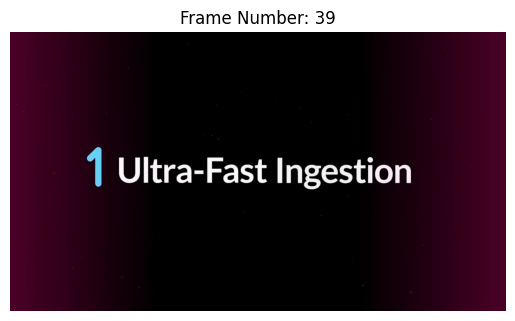

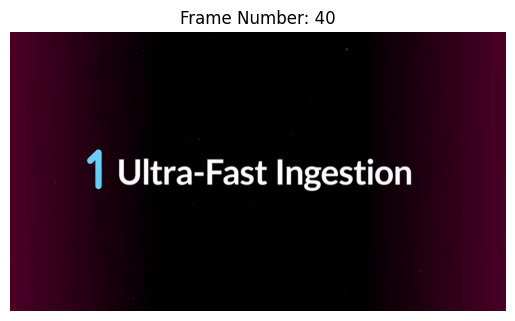

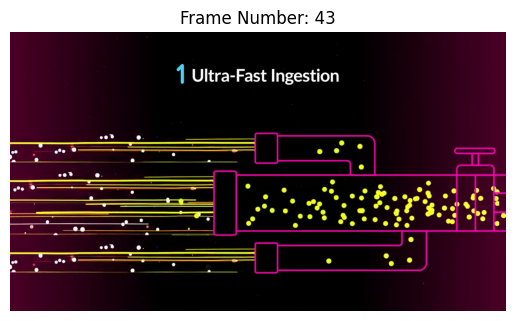

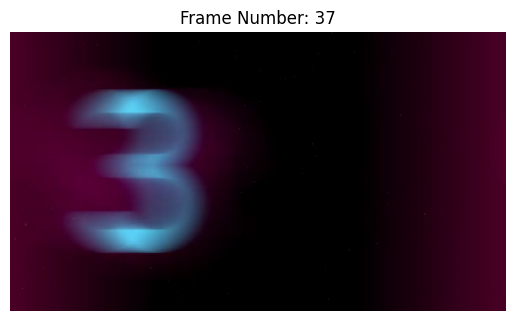

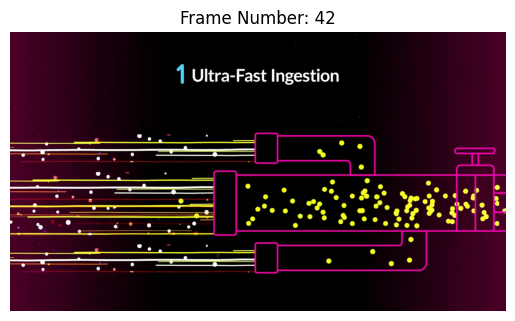

In [31]:
import matplotlib.pyplot as plt

def plot_frame(frame_data, frame_number):
    plt.imshow(frame_data)
    plt.title(f"Frame Number: {frame_number}")
    plt.axis("off")
    plt.show()

top_text_matches_indices = top_text_matches.index.tolist()
for index in top_text_matches_indices:
    frame_number = df.loc[index, "frame_number"]
    frame_data = df.loc[index, "frame_data"]
    plot_frame(frame_data, frame_number)

## Example image query
### Encode image into a vector representation

**TL;DR**</br>
Summarise an image in a simpler numerical form.

**Summary**</br>
Preprocess an input image, pass it through a model to extract features, and return the resulting feature vector. This feature vector can then be used for similarity calculations.

In [32]:
def encode_image_query(image):
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
    return image_features.cpu().numpy()[0]

In [35]:
import requests
from IPython.display import Image, display
from PIL import Image as PILImage
from io import BytesIO

# What Makes SingleStoreDB Unique?
image_url = "https://i.ytimg.com/vi/C29owZyi6XE/maxresdefault.jpg"
# What Makes SingleStoreDB Fast?
# image_url = "https://i.ytimg.com/vi/ZKaZ89-Yijg/maxresdefault.jpg"
# Streaming Data Ingestion
# image_url = "https://i.ytimg.com/vi/3BiyiH-eyLM/maxresdefault.jpg"

response = requests.get(image_url)

if response.status_code == 200:
    display(Image(url = image_url))
    image_file = PILImage.open(BytesIO(response.content))

    image_query_embedding = encode_image_query(image_file)
    image_similarities = calculate_similarity(image_query_embedding, df)
    df["image_similarity"] = image_similarities
else:
    print("Failed to download the image, status code:", response.status_code)

### Find the top 5 best matches

In [36]:
top_image_matches = df.nlargest(5, "image_similarity")

print("Top 5 best matches:")
print(top_image_matches[["frame_number", "image_similarity"]].to_string(index = False))

Top 5 best matches:
 frame_number  image_similarity
            7         59.924870
            9         46.626740
            6         45.452797
           15         42.308662
            5         41.954895


### Show the frames

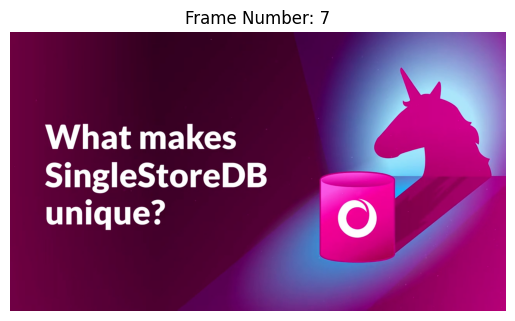

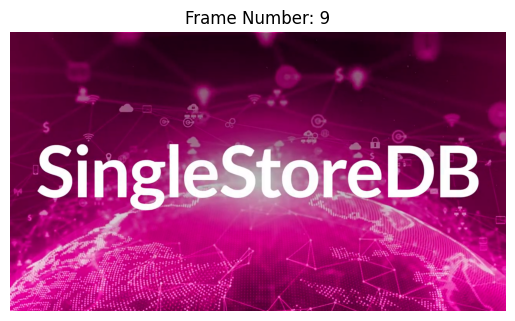

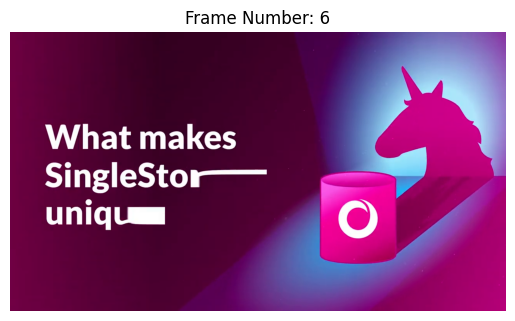

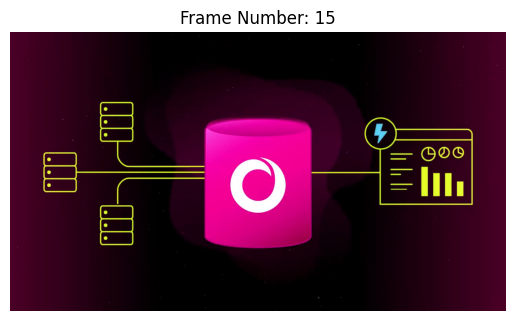

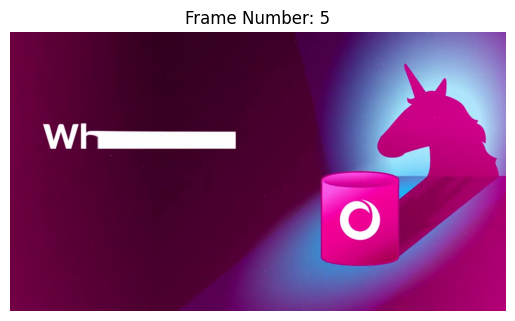

In [37]:
top_image_matches_indices = top_image_matches.index.tolist()
for index in top_image_matches_indices:
    frame_number = df.loc[index, "frame_number"]
    frame_data = df.loc[index, "frame_data"]
    plot_frame(frame_data, frame_number)

## Example combined query

**TL;DR**</br>
When using CLIP with both text and images in a query, balance them by element-wise averaging.

**Summary**</br>
Balancing a query that includes both text and images when using CLIP involves finding an appropriate way to combine the embeddings of the textual query and the image query. A common approach is to use element-wise averaging.

Element-wise averaging means taking the average of corresponding elements in the two embeddings. This is done by adding the elements of the two embeddings together and then dividing by the number of elements. This ensures that both the textual and visual aspects of the query contribute equally to the final representation.

CLIP generates embeddings for both images and text using the ViT model. This model processes both images and text by first converting them into a common feature space through a shared set of transformer layers. The embeddings produced for images and text have the same dimensionality.

In [38]:
combined_query_embedding = (text_query_embedding + image_query_embedding) / 2
combined_similarities = calculate_similarity(combined_query_embedding, df)
df["combined_similarity"] = combined_similarities

### Find the top 5 best matches

In [39]:
top_combined_matches = df.nlargest(5, "combined_similarity")

print("Top 5 best matches:")
print(top_combined_matches[["frame_number", "combined_similarity"]].to_string(index = False))

Top 5 best matches:
 frame_number  combined_similarity
            7            37.805325
            5            34.681156
           13            34.545235
           16            34.423401
            6            34.322884


### Show the frames

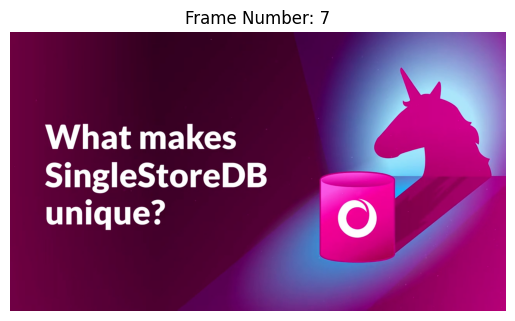

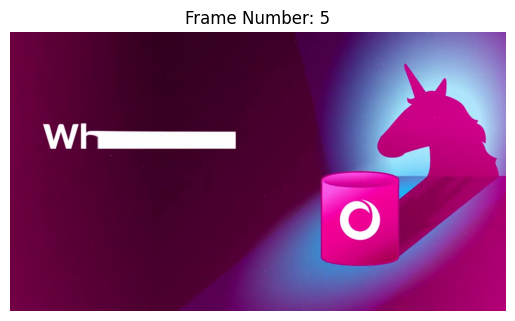

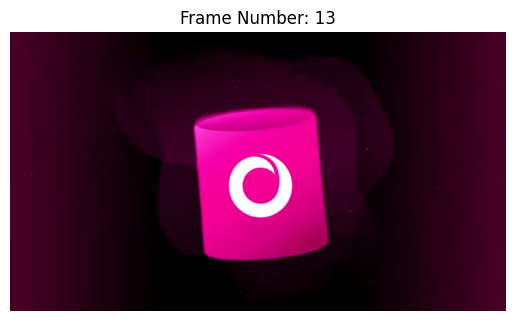

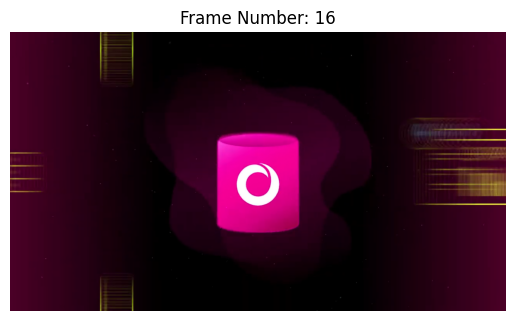

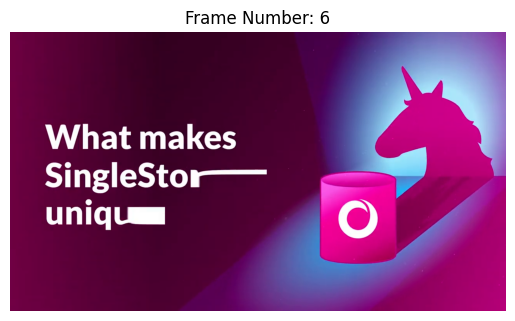

In [40]:
top_combined_matches_indices = top_combined_matches.index.tolist()
for index in top_combined_matches_indices:
    frame_number = df.loc[index, "frame_number"]
    frame_data = df.loc[index, "frame_data"]
    plot_frame(frame_data, frame_number)

## Database operations
### Prepare the data for SingleStore

In [41]:
frames_df = df.copy()
frames_df.drop(
    columns = ["text_similarity", "image_similarity", "combined_similarity"],
    inplace = True
)

query_string = combined_query_embedding.copy()

### Convert the arrays to string representations

In [42]:
def process_data(arr):
    return np.array2string(arr, separator = ",").replace("\n", "")

frames_df["embedding_data"] = frames_df["embedding_data"].apply(process_data)
frames_df["frame_data"] = frames_df["frame_data"].apply(process_data)
query_string = process_data(query_string)

In [43]:
frames_df.head()

,frame_number,embedding_data,frame_data
0,1,"[ 4.56542242e-03,-1.08384579e-01,-1.50397032e-...","[[[126, 0, 73], [126, 0, 73], [126, 0, 73..."
1,2,"[ 2.20647648e-01,-2.17137247e-01,-2.66866267e-...","[[[126, 0, 73], [126, 0, 73], [125, 0, 72..."
2,3,"[-1.70631886e-01, 7.52555951e-02, 1.80819780e-...","[[[126, 0, 73], [126, 0, 73], [125, 0, 72..."
3,4,"[-1.48093730e-01, 6.71142638e-02, 2.37201124e-...","[[[126, 0, 73], [126, 0, 73], [125, 0, 72..."
4,5,"[ 2.27201413e-02, 7.51351714e-02, 5.45280986e-...","[[[109, 0, 66], [108, 0, 65], [108, 0, 65..."


### Create the database and table

In [44]:
%%sql
DROP DATABASE IF EXISTS video_db;
CREATE DATABASE IF NOT EXISTS video_db;

++
||
++
++

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p>Select the database from the drop-down menu at the top of this notebook. It updates the <b>connection_url</b> which is used by SQLAlchemy to make connections to the selected database.</p>
    </div>
</div>

In [46]:
from sqlalchemy import *

db_connection = create_engine(connection_url)

In [47]:
%%sql
CREATE TABLE IF NOT EXISTS frames (
    frame_number INT(10) UNSIGNED NOT NULL,
    embedding_data VECTOR(512) NOT NULL,
    frame_data TEXT,
    KEY(frame_number)
);

++
||
++
++

### Write the DataFrame to SingleStore

In [48]:
frames_df.to_sql(
    "frames",
    con = db_connection,
    if_exists = "append",
    index = False,
    chunksize = 1000
)

142

### Read back some data

In [49]:
%%sql
SELECT frame_number,
    SUBSTRING(embedding_data, 1, 50) AS embedding_data,
    SUBSTRING(frame_data, 1, 50) AS frame_data
FROM frames
LIMIT 1;

frame_number,embedding_data,frame_data
140,"[-0.0883750543,0.321317226,0.0392855108,-0.1057859","[[[74, 0,39], [74, 0,39], [74, 0,39], ..., [74"


### Create the ANN index

In [50]:
%%sql
ALTER TABLE frames ADD VECTOR INDEX (embedding_data)
     INDEX_OPTIONS '{
          "index_type":"AUTO",
          "metric_type":"DOT_PRODUCT"
     }';

++
||
++
++

## Example query

In [51]:
%config SqlMagic.named_parameters = True

### Dot Product without ANN index

In [52]:
%%sql
SELECT frame_number,
    embedding_data <*> :query_string AS similarity
FROM frames
ORDER BY similarity USE INDEX () DESC
LIMIT 5;

frame_number,similarity
7,37.80531692504883
5,34.681156158447266
13,34.54522705078125
16,34.42340087890625
6,34.322879791259766


### Dot Product with ANN index

In [53]:
%%sql
SELECT frame_number,
    embedding_data <*> :query_string AS similarity
FROM frames
ORDER BY similarity DESC
LIMIT 5;

frame_number,similarity
7,37.80531692504883
5,34.681156158447266
13,34.54522705078125
16,34.42340087890625
6,34.322879791259766


In [54]:
sql_query = """
SELECT frame_number, embedding_data, frame_data
FROM frames
ORDER BY embedding_data <*> %s DESC
LIMIT 5;
"""

new_frames_df = pd.read_sql(
    sql_query,
    con = db_connection,
    params = (query_string,)
)

In [55]:
new_frames_df.head()

,frame_number,embedding_data,frame_data
0,7,"[0.44968152,-0.138281301,-0.0819440559,-0.2873...","[[[108, 0, 63], [108, 0, 63], [108, 0, 63..."
1,5,"[0.0227201413,0.0751351714,0.00545280986,0.194...","[[[109, 0, 66], [108, 0, 65], [108, 0, 65..."
2,13,"[-0.0462057926,0.100246005,-0.0190070234,-0.21...","[[[73, 0,42], [72, 0,41], [72, 0,41], ..., ..."
3,16,"[-0.0935820937,-0.0245336648,0.00776154129,-0....","[[[74, 0,38], [74, 0,38], [74, 0,38], ..., ..."
4,6,"[0.0417270549,-0.151123881,0.0925379843,-0.073...","[[[109, 0, 66], [108, 0, 65], [108, 0, 65..."


## Limitations

- **Frame Extraction:** Frames are extracted at a fixed interval based on the frame rate. This could miss important frames or include redundant ones.

- **Embedding Generation:** Each frame is processed individually, which is inefficient for large videos. Batch processing multiple frames at once to use parallelism should improve performance.

- **Similarity Calculation:** Similarities between the query embedding and all frame embeddings are calculated sequentially. This could be parallelized to speed up computation, especially for large videos with many frames.